In [1]:
import polars as pl
from collections import Counter
from sklearn.metrics import jaccard_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Métricas

En este notebook se va a realizar un estudio de las métricas. Estas métricas surgen de las predicciones hechas por el LLM y las predicciones hechas por humanos. 

## Carga de datos

In [2]:
# Datos reales
data_real = pl.read_csv('/home/joselu/tfm/adapted-work/data/validated_data.csv')

# Prompt 1
p1_gemma = pl.read_json('/home/joselu/tfm/adapted-work/data/prompt_1/gemma.json')
p1_deepseek = pl.read_json('/home/joselu/tfm/adapted-work/data/prompt_1/deepseek8.json')
# p1_qwen = pl.read_csv('/home/joselu/tfm/adapted-work/data/prompt_1/validated_data.csv')

# Prompt 2
p2_gemma = pl.read_json('/home/joselu/tfm/adapted-work/data/prompt_2/gemma.json')
# p2_deepseek = pl.read_csv('/home/joselu/tfm/adapted-work/data/prompt_2/validated_data.csv')
# p2_qwen = pl.read_csv('/home/joselu/tfm/adapted-work/data/prompt_2/validated_data.csv')

# Prompt 3
p3_gemma = pl.read_json('/home/joselu/tfm/adapted-work/data/prompt_3/gemma.json')
p3_deepseek = pl.read_json('/home/joselu/tfm/adapted-work/data/prompt_3/deepseek8.json')
# p3_qwen = pl.read_csv('/home/joselu/tfm/adapted-work/data/prompt_3/validated_data.csv# ')

## Cargar funciones

In [3]:
def clean_labels(label_string):
    return set(l.strip().lower() for l in label_string.replace('\n', '').replace(' del habla','del habla').split(',') if l.strip())

# Asumiendo que real_set y pred_set son listas de sets del mismo tamaño
def calculate_set_metrics(real_sets, pred_sets):
    metrics = {
        'jaccard_scores': [],
        'precision_scores': [],
        'recall_scores': [],
        'f1_scores': []
    }
    
    for real, pred in zip(real_sets, pred_sets):
        # Jaccard Index
        intersection = len(real & pred)
        union = len(real | pred)
        jaccard = intersection / union if union > 0 else 0
        
        # Precision
        precision = intersection / len(pred) if len(pred) > 0 else 0
        
        # Recall
        recall = intersection / len(real) if len(real) > 0 else 0
        
        # F1 Score
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        metrics['jaccard_scores'].append(jaccard)
        metrics['precision_scores'].append(precision)
        metrics['recall_scores'].append(recall)
        metrics['f1_scores'].append(f1)
    
    return metrics

def analyze_label_distribution(real_sets, pred_sets):
    # Contar frecuencias
    real_counts = {}
    pred_counts = {}
    
    for s in real_sets:
        for label in s:
            real_counts[label] = real_counts.get(label, 0) + 1
    
    for s in pred_sets:
        for label in s:
            pred_counts[label] = pred_counts.get(label, 0) + 1
    
    # Crear DataFrame para comparación
    all_labels = set(real_counts.keys()) | set(pred_counts.keys())
    
    comparison_df = pd.DataFrame({
        'Real': [real_counts.get(label, 0) for label in all_labels],
        'Predicho': [pred_counts.get(label, 0) for label in all_labels]
    }, index=list(all_labels))
    
    return comparison_df

def exact_match_analysis(real_sets, pred_sets):
    exact_matches = sum(1 for r, p in zip(real_sets, pred_sets) if r == p)
    total = len(real_sets)
    
    print(f"Coincidencias exactas: {exact_matches}/{total} ({exact_matches/total*100:.2f}%)")
    
    # Análisis de casos comunes
    from collections import Counter
    
    real_combinations = Counter([frozenset(s) for s in real_sets])
    pred_combinations = Counter([frozenset(s) for s in pred_sets])
    
    print("\nCombinaciones más comunes (Real):")
    for combo, count in real_combinations.most_common(5):
        print(f"  {set(combo)}: {count}")
    
    print("\nCombinaciones más comunes (Predicho):")
    for combo, count in pred_combinations.most_common(5):
        print(f"  {set(combo)}: {count}")

## Métricas

### Limpiar datasets

In [4]:
real_set = []

for dat in data_real["pred_disability"]:
    real_set.append(clean_labels(dat))

print(real_set)

[{'del habla', 'psicosocial', 'motriz', 'auditiva', 'visual'}, {'del habla', 'psicosocial', 'motriz', 'auditiva', 'visual'}, {'del habla', 'psicosocial', 'motriz', 'auditiva', 'visual'}, {'auditiva', 'psicosocial', 'del habla', 'motriz'}, {'auditiva', 'psicosocial', 'del habla', 'motriz'}, {'auditiva', 'psicosocial', 'del habla', 'motriz'}, {'auditiva', 'del habla', 'motriz'}, {'auditiva', 'del habla', 'motriz'}, {'auditiva', 'del habla', 'motriz'}, {'auditiva', 'psicosocial', 'del habla', 'motriz'}, {'auditiva', 'psicosocial', 'del habla', 'motriz'}, {'auditiva', 'psicosocial', 'del habla', 'motriz'}, {'auditiva', 'del habla', 'motriz'}, {'auditiva', 'psicosocial', 'del habla', 'motriz'}, {'del habla', 'psicosocial', 'motriz', 'auditiva', 'visual'}, {'auditiva', 'psicosocial', 'del habla', 'motriz'}, {'auditiva', 'psicosocial', 'del habla', 'motriz'}, {'auditiva', 'psicosocial', 'del habla', 'motriz'}, {'auditiva', 'psicosocial', 'del habla', 'motriz'}, {'auditiva', 'del habla', 'motr

#### Prompt 1

In [5]:
p1_gemma_set = []

for dat in p1_gemma["pred_disability"]:
    p1_gemma_set.append(clean_labels(dat))

In [6]:
p1_deepseek_set = []

for dat in p1_deepseek["pred_disability"]:
    p1_deepseek_set.append(clean_labels(dat))

#### Prompt 2

In [7]:
p2_gemma_set = []

for dat in p2_gemma["pred_disability"]:
    p2_gemma_set.append(clean_labels(dat))

#### Prompt 3

In [8]:
p3_gemma_set = []

for dat in p3_gemma["pred_disability"]:
    p3_gemma_set.append(clean_labels(dat))

In [9]:
p3_deepseek_set = []

for dat in p3_deepseek["pred_disability"]:
    p3_deepseek_set.append(clean_labels(dat))

### Cálculo de métricas

#### Prompt 1
##### Gemma

In [10]:
metrics = calculate_set_metrics(real_set, p1_gemma_set)

# Estadísticas resumen
print("Métricas promedio:")
print(f"Jaccard Index: {np.mean(metrics['jaccard_scores']):.3f} ± {np.std(metrics['jaccard_scores']):.3f}")
print(f"Precision: {np.mean(metrics['precision_scores']):.3f} ± {np.std(metrics['precision_scores']):.3f}")
print(f"Recall: {np.mean(metrics['recall_scores']):.3f} ± {np.std(metrics['recall_scores']):.3f}")
print(f"F1 Score: {np.mean(metrics['f1_scores']):.3f} ± {np.std(metrics['f1_scores']):.3f}")

Métricas promedio:
Jaccard Index: 0.259 ± 0.113
Precision: 0.552 ± 0.199
Recall: 0.322 ± 0.132
F1 Score: 0.399 ± 0.145


Distribución de etiquetas:
             Real  Predicho
intelectual     0         2
del habla     122         9
psicosocial    90        41
motriz        121       107
auditiva      122        11
física          0         2
cognitiva      10       121
visual         53         5


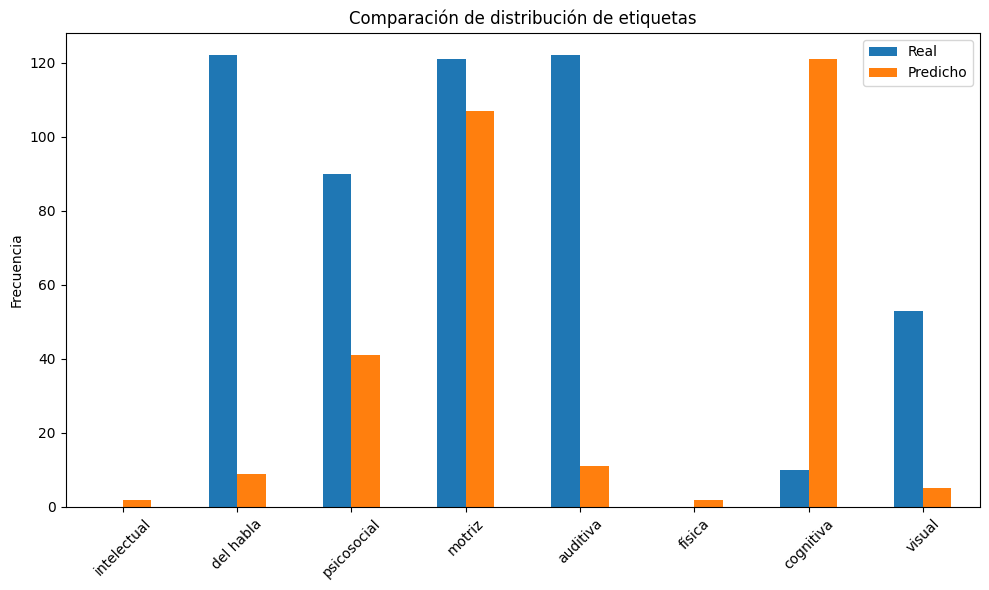

In [11]:
# Análisis de distribución
dist_df = analyze_label_distribution(real_set, p1_gemma_set)
print("Distribución de etiquetas:")
print(dist_df)

# Visualización
dist_df.plot(kind='bar', figsize=(10, 6))
plt.title('Comparación de distribución de etiquetas')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Distribución de etiquetas:
   Real  Predicho  Diferencia Absoluta  Diferencia Relativa (%)
A     2         2                    0                 0.000000
B     1         2                    1               100.000000
C     3         2                    1                33.333333


ValueError: 'facecolor' or 'color' argument must be a valid color orsequence of colors.

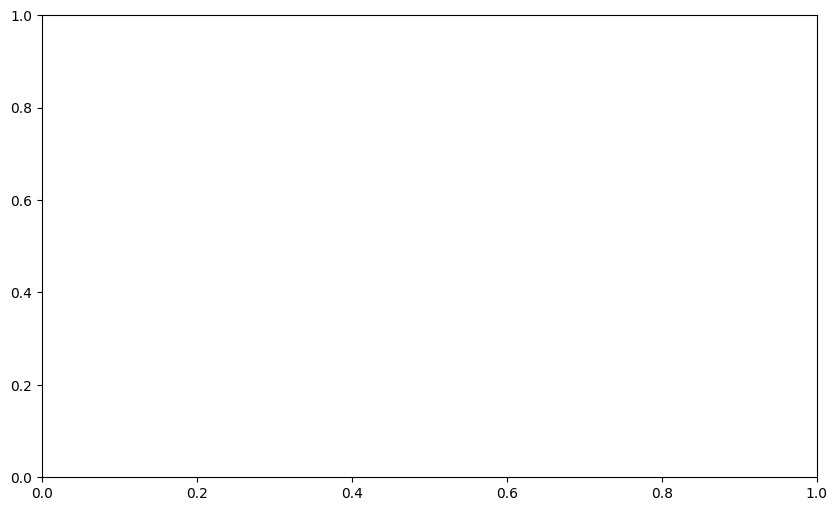

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def analyze_label_distribution(real_set, pred_set):
    # Convert elements to strings to handle unhashable types (e.g., lists, sets)
    real_set = [str(item) for item in real_set]
    pred_set = [str(item) for item in pred_set]
    
    # Compute frequency counts
    real_counts = pd.Series(real_set).value_counts().sort_index()
    pred_counts = pd.Series(pred_set).value_counts().sort_index()
    
    # Get unique labels (union of indices)
    labels = sorted(set(real_counts.index).union(set(pred_counts.index)))
    
    # Create DataFrame with real and predicted frequencies
    dist_df = pd.DataFrame({
        'Real': real_counts.reindex(labels, fill_value=0),
        'Predicho': pred_counts.reindex(labels, fill_value=0)
    })
    
    # Calculate absolute and relative differences
    dist_df['Diferencia Absoluta'] = abs(dist_df['Real'] - dist_df['Predicho'])
    dist_df['Diferencia Relativa (%)'] = (dist_df['Diferencia Absoluta'] / dist_df['Real'] * 100).replace([np.inf, -np.inf], 0).fillna(0)
    
    return dist_df

# Example data (replace with your actual real_set and p1_gemma_set)
# For testing, assuming labels are categories like 'A', 'B', 'C'
real_set = ['A', 'A', 'B', 'C', 'C', 'C']
p1_gemma_set = ['A', 'B', 'B', 'C', 'A', 'C']

# Analyze distribution
dist_df = analyze_label_distribution(real_set, p1_gemma_set)
print("Distribución de etiquetas:")
print(dist_df)

# Visualization: Bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
x = np.arange(len(dist_df.index))
ax.bar(x - bar_width/2, dist_df['Real'], bar_width, label='Real', color='rgba(54, 162, 235, 0.7)')
ax.bar(x + bar_width/2, dist_df['Predicho'], bar_width, label='Predicho', color='rgba(255, 99, 132, 0.7)')

# Add data labels
for i, v in enumerate(dist_df['Real']):
    ax.text(i - bar_width/2, v + 0.5, str(int(v)), ha='center', va='bottom')
for i, v in enumerate(dist_df['Predicho']):
    ax.text(i + bar_width/2, v + 0.5, str(int(v)), ha='center', va='bottom')

plt.title('Comparación de distribución de etiquetas: Real vs. Predicho')
plt.xlabel('Etiqueta')
plt.ylabel('Frecuencia')
plt.xticks(x, dist_df.index, rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('distribucion_etiquetas.png')  # Save for LaTeX
plt.show()

# Confusion matrix
cm = confusion_matrix(real_set, p1_gemma_set, labels=dist_df.index)
cm_df = pd.DataFrame(cm, index=dist_df.index, columns=dist_df.index)
print("Matriz de confusión:")
print(cm_df)

# Visualization: Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')


In [13]:
exact_match_analysis(real_set, p1_gemma_set)

Coincidencias exactas: 0/122 (0.00%)

Combinaciones más comunes (Real):
  {'psicosocial', 'visual', 'del habla', 'motriz', 'auditiva'}: 43
  {'del habla', 'auditiva', 'motriz', 'psicosocial'}: 39
  {'del habla', 'auditiva', 'motriz'}: 29
  {'psicosocial', 'visual', 'del habla', 'motriz', 'cognitiva', 'auditiva'}: 7
  {'del habla', 'visual', 'motriz', 'cognitiva', 'auditiva'}: 3

Combinaciones más comunes (Predicho):
  {'cognitiva', 'motriz'}: 53
  {'psicosocial', 'cognitiva', 'motriz'}: 28
  {'psicosocial', 'cognitiva'}: 12
  {'auditiva', 'cognitiva', 'motriz'}: 11
  {'del habla', 'cognitiva', 'motriz'}: 9


##### DeepSeek

In [14]:
metrics = calculate_set_metrics(real_set, p1_deepseek_set)

# Estadísticas resumen
print("Métricas promedio:")
print(f"Jaccard Index: {np.mean(metrics['jaccard_scores']):.3f} ± {np.std(metrics['jaccard_scores']):.3f}")
print(f"Precision: {np.mean(metrics['precision_scores']):.3f} ± {np.std(metrics['precision_scores']):.3f}")
print(f"Recall: {np.mean(metrics['recall_scores']):.3f} ± {np.std(metrics['recall_scores']):.3f}")
print(f"F1 Score: {np.mean(metrics['f1_scores']):.3f} ± {np.std(metrics['f1_scores']):.3f}")

Métricas promedio:
Jaccard Index: 0.057 ± 0.069
Precision: 0.063 ± 0.077
Recall: 0.261 ± 0.297
F1 Score: 0.099 ± 0.119


#### Prompt 2
##### Gemma 

In [15]:
metrics = calculate_set_metrics(real_set, p2_gemma_set)

# Estadísticas resumen
print("Métricas promedio:")
print(f"Jaccard Index: {np.mean(metrics['jaccard_scores']):.3f} ± {np.std(metrics['jaccard_scores']):.3f}")
print(f"Precision: {np.mean(metrics['precision_scores']):.3f} ± {np.std(metrics['precision_scores']):.3f}")
print(f"Recall: {np.mean(metrics['recall_scores']):.3f} ± {np.std(metrics['recall_scores']):.3f}")
print(f"F1 Score: {np.mean(metrics['f1_scores']):.3f} ± {np.std(metrics['f1_scores']):.3f}")

Métricas promedio:
Jaccard Index: 0.676 ± 0.211
Precision: 0.962 ± 0.165
Recall: 0.682 ± 0.207
F1 Score: 0.785 ± 0.182


Distribución de etiquetas:
             Real  Predicho
motriz        121       117
visual         53         7
auditiva      122       101
psicosocial    90         4
cognitiva      10         7
del habla     122       112


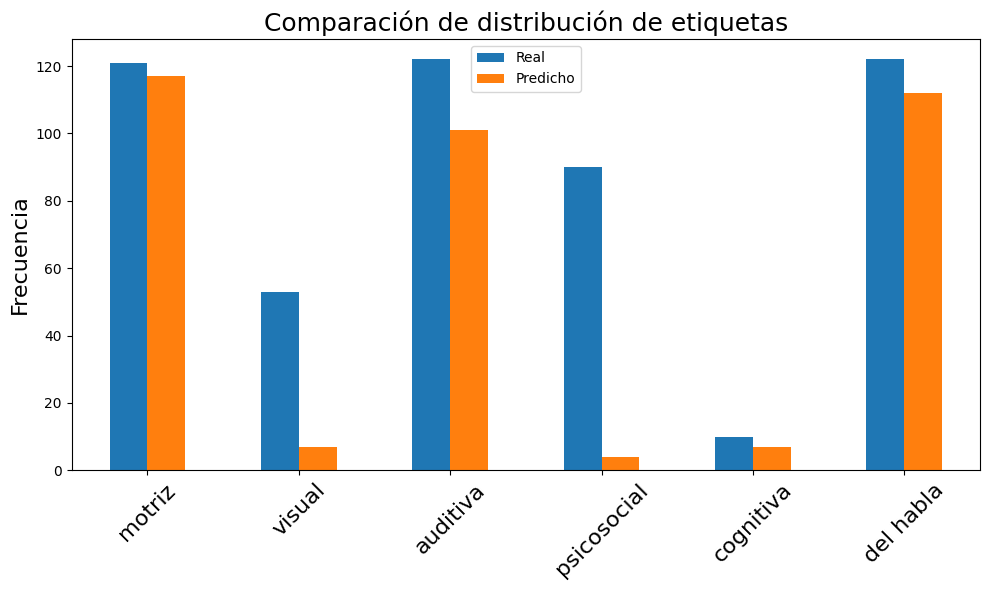

In [18]:
# Análisis de distribución
dist_df = analyze_label_distribution(real_set, p2_gemma_set)
print("Distribución de etiquetas:")
print(dist_df)

# Visualización
dist_df.plot(kind='bar', figsize=(10, 6))
plt.title('Comparación de distribución de etiquetas', fontsize=18)
plt.ylabel('Frecuencia', fontsize=16)
plt.xticks(rotation=45, fontsize=16)
plt.tight_layout()
plt.show()

In [17]:
exact_match_analysis(real_set, p2_gemma_set)

Coincidencias exactas: 22/122 (18.03%)

Combinaciones más comunes (Real):
  {'psicosocial', 'visual', 'del habla', 'motriz', 'auditiva'}: 43
  {'del habla', 'auditiva', 'motriz', 'psicosocial'}: 39
  {'del habla', 'auditiva', 'motriz'}: 29
  {'psicosocial', 'visual', 'del habla', 'motriz', 'cognitiva', 'auditiva'}: 7
  {'del habla', 'visual', 'motriz', 'cognitiva', 'auditiva'}: 3

Combinaciones más comunes (Predicho):
  {'del habla', 'auditiva', 'motriz'}: 100
  {'cognitiva'}: 5
  {'del habla', 'motriz'}: 5
  {'del habla', 'visual', 'motriz'}: 5
  {'psicosocial', 'motriz'}: 4


#### Prompt 3
##### Gemma

In [19]:
metrics = calculate_set_metrics(real_set, p3_gemma_set)

# Estadísticas resumen
print("Métricas promedio:")
print(f"Jaccard Index: {np.mean(metrics['jaccard_scores']):.3f} ± {np.std(metrics['jaccard_scores']):.3f}")
print(f"Precision: {np.mean(metrics['precision_scores']):.3f} ± {np.std(metrics['precision_scores']):.3f}")
print(f"Recall: {np.mean(metrics['recall_scores']):.3f} ± {np.std(metrics['recall_scores']):.3f}")
print(f"F1 Score: {np.mean(metrics['f1_scores']):.3f} ± {np.std(metrics['f1_scores']):.3f}")

Métricas promedio:
Jaccard Index: 0.723 ± 0.170
Precision: 0.997 ± 0.030
Recall: 0.725 ± 0.169
F1 Score: 0.829 ± 0.110


Distribución de etiquetas:
             Real  Predicho
motriz        121       122
visual         53         0
auditiva      122       122
psicosocial    90         0
cognitiva      10         0
del habla     122       116


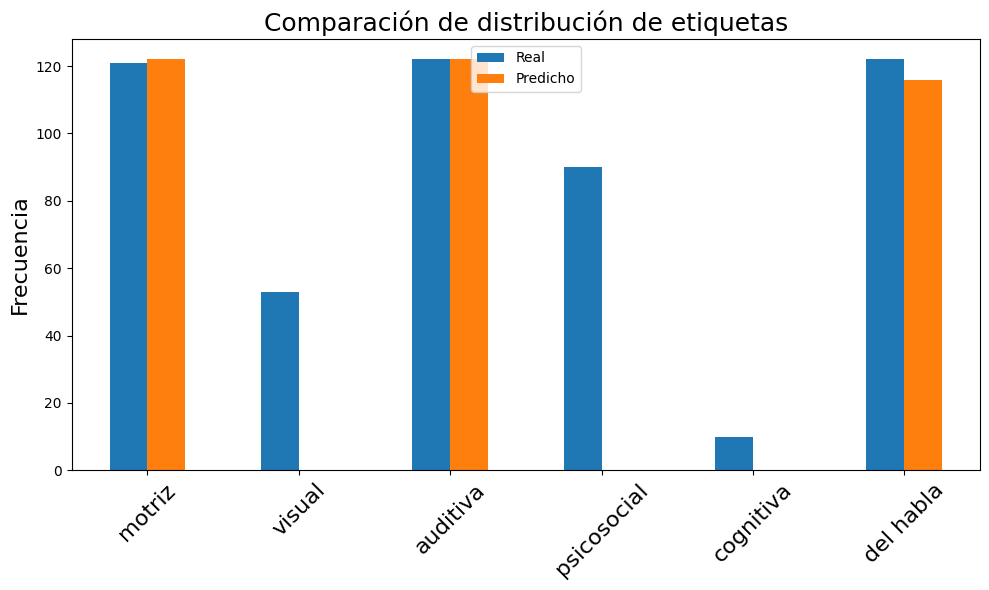

In [20]:
# Análisis de distribución
dist_df = analyze_label_distribution(real_set, p3_gemma_set)
print("Distribución de etiquetas:")
print(dist_df)

# Visualización
dist_df.plot(kind='bar', figsize=(10, 6))
plt.title('Comparación de distribución de etiquetas', fontsize=18)
plt.ylabel('Frecuencia', fontsize=16)
plt.xticks(rotation=45, fontsize=16)
plt.tight_layout()
plt.show()

In [20]:
exact_match_analysis(real_set, p3_gemma_set)

Coincidencias exactas: 28/122 (22.95%)

Combinaciones más comunes (Real):
  {'psicosocial', 'visual', 'del habla', 'motriz', 'auditiva'}: 43
  {'del habla', 'auditiva', 'motriz', 'psicosocial'}: 39
  {'del habla', 'auditiva', 'motriz'}: 29
  {'psicosocial', 'visual', 'del habla', 'motriz', 'cognitiva', 'auditiva'}: 7
  {'del habla', 'visual', 'motriz', 'cognitiva', 'auditiva'}: 3

Combinaciones más comunes (Predicho):
  {'del habla', 'auditiva', 'motriz'}: 116
  {'auditiva', 'motriz'}: 6


##### DeepSeek

In [21]:
metrics = calculate_set_metrics(real_set, p3_deepseek_set)

# Estadísticas resumen
print("Métricas promedio:")
print(f"Jaccard Index: {np.mean(metrics['jaccard_scores']):.3f} ± {np.std(metrics['jaccard_scores']):.3f}")
print(f"Precision: {np.mean(metrics['precision_scores']):.3f} ± {np.std(metrics['precision_scores']):.3f}")
print(f"Recall: {np.mean(metrics['recall_scores']):.3f} ± {np.std(metrics['recall_scores']):.3f}")
print(f"F1 Score: {np.mean(metrics['f1_scores']):.3f} ± {np.std(metrics['f1_scores']):.3f}")

Métricas promedio:
Jaccard Index: 0.721 ± 0.172
Precision: 0.997 ± 0.031
Recall: 0.722 ± 0.171
F1 Score: 0.826 ± 0.113


Distribución de etiquetas:
             Real  Predicho
motriz        121       113
visual         53         0
auditiva      122       113
psicosocial    90         0
cognitiva      10         0
del habla     122       107


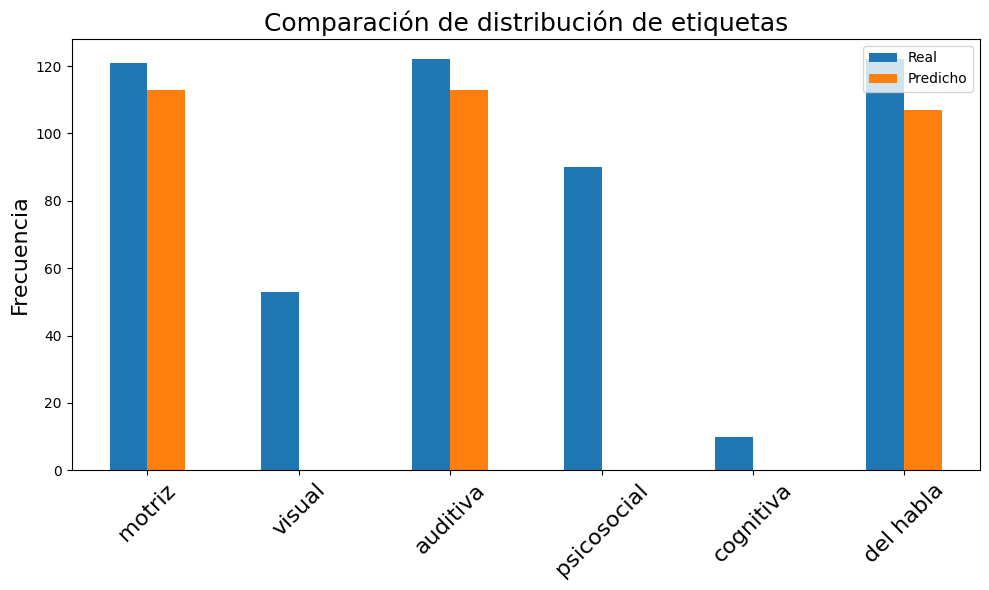

In [23]:
# Análisis de distribución
dist_df = analyze_label_distribution(real_set, p3_deepseek_set)
print("Distribución de etiquetas:")
print(dist_df)

# Visualización
dist_df.plot(kind='bar', figsize=(10, 6))
plt.title('Comparación de distribución de etiquetas', fontsize=18)
plt.ylabel('Frecuencia', fontsize=16)
plt.xticks(rotation=45, fontsize=16)
plt.tight_layout()
plt.show()

In [23]:
exact_match_analysis(real_set, p3_deepseek_set)

Coincidencias exactas: 25/122 (20.49%)

Combinaciones más comunes (Real):
  {'psicosocial', 'visual', 'del habla', 'motriz', 'auditiva'}: 43
  {'del habla', 'auditiva', 'motriz', 'psicosocial'}: 39
  {'del habla', 'auditiva', 'motriz'}: 29
  {'psicosocial', 'visual', 'del habla', 'motriz', 'cognitiva', 'auditiva'}: 7
  {'del habla', 'visual', 'motriz', 'cognitiva', 'auditiva'}: 3

Combinaciones más comunes (Predicho):
  {'del habla', 'auditiva', 'motriz'}: 107
  {'auditiva', 'motriz'}: 6


Distribución de etiquetas:
      Etiqueta  Real_Set  P3_DeepSeek_Set  Dataset_3  Dataset_4
0     auditiva         7                7          7          7
1    cognitiva         1                0          1          0
2    del habla         8                8          8          8
3       motriz         8                8          7          7
4  psicosocial         6                6          4          4
5       visual         4                3          3          3


<Figure size 1400x800 with 0 Axes>

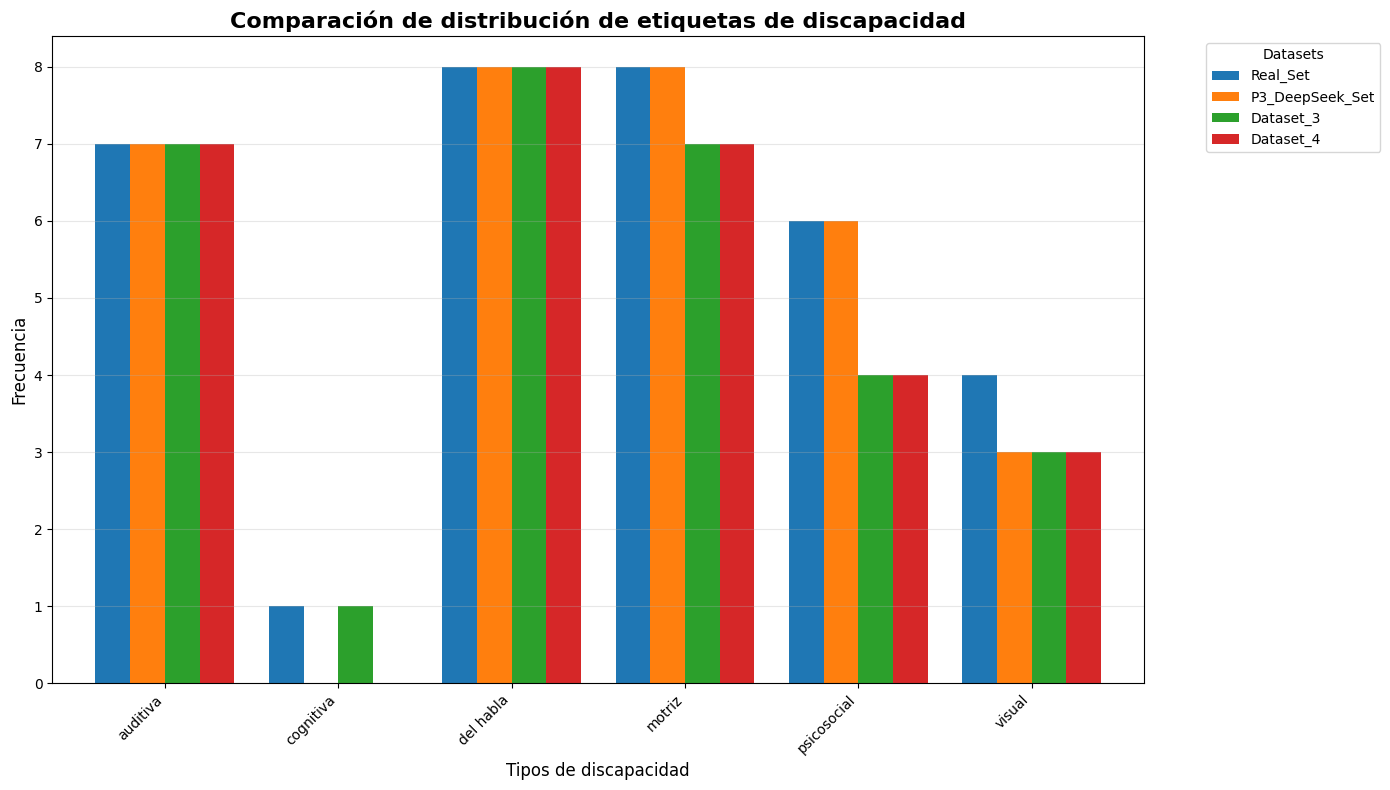


Estadísticas por dataset:
Real_Set:
  Total ocurrencias: 34
  Frecuencia media: 5.67
  Frecuencia máxima: 8

P3_DeepSeek_Set:
  Total ocurrencias: 32
  Frecuencia media: 5.33
  Frecuencia máxima: 8

Dataset_3:
  Total ocurrencias: 30
  Frecuencia media: 5.00
  Frecuencia máxima: 8

Dataset_4:
  Total ocurrencias: 29
  Frecuencia media: 4.83
  Frecuencia máxima: 8


Análisis de combinaciones más frecuentes en Real Set:
  ('auditiva', 'del habla', 'motriz', 'psicosocial', 'visual'): 2 veces
  ('auditiva', 'del habla', 'motriz', 'psicosocial'): 2 veces
  ('auditiva', 'del habla', 'motriz'): 1 veces
  ('auditiva', 'cognitiva', 'del habla', 'motriz', 'psicosocial', 'visual'): 1 veces
  ('auditiva', 'del habla', 'motriz', 'visual'): 1 veces

Análisis de combinaciones más frecuentes en P3 DeepSeek Set:
  ('auditiva', 'del habla', 'motriz', 'psicosocial'): 3 veces
  ('auditiva', 'del habla', 'motriz', 'psicosocial', 'visual'): 2 veces
  ('auditiva', 'del habla', 'motriz'): 1 veces
  ('auditiv

<Figure size 1200x600 with 0 Axes>

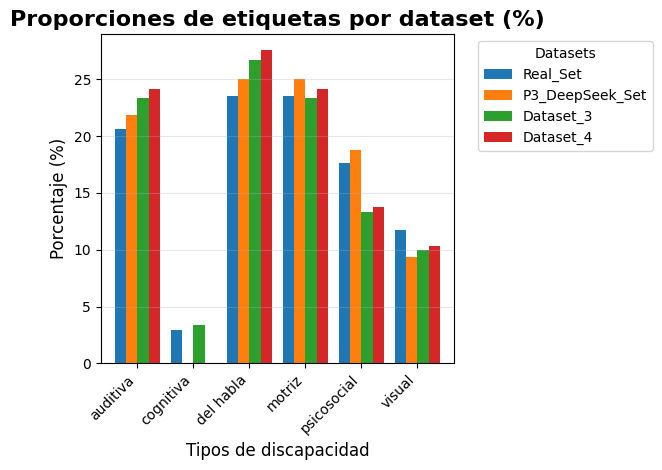


Similitud entre datasets (1 - distancia coseno):
Real_Set vs P3_DeepSeek_Set: 0.996
Real_Set vs Dataset_3: 0.991
Real_Set vs Dataset_4: 0.988
P3_DeepSeek_Set vs Dataset_3: 0.989
P3_DeepSeek_Set vs Dataset_4: 0.991
Dataset_3 vs Dataset_4: 0.997


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def analyze_label_distribution(real_set, p3_deepseek_set, dataset_3, dataset_4):
    """
    Analiza la distribución de etiquetas en múltiples datasets multi-label
    
    Args:
        real_set: Lista de sets con etiquetas de discapacidad
        p3_deepseek_set: Lista de sets con etiquetas de discapacidad
        dataset_3: Lista de sets con etiquetas de discapacidad
        dataset_4: Lista de sets con etiquetas de discapacidad
    
    Returns:
        DataFrame con la distribución de etiquetas
    """
    
    def count_labels_in_dataset(dataset):
        """Cuenta la frecuencia de cada etiqueta en un dataset multi-label"""
        label_counts = Counter()
        for label_set in dataset:
            for label in label_set:
                label_counts[label] += 1
        return label_counts
    
    # Contar frecuencias en cada dataset
    real_counts = count_labels_in_dataset(real_set)
    p3_counts = count_labels_in_dataset(p3_deepseek_set)
    d3_counts = count_labels_in_dataset(dataset_3)
    d4_counts = count_labels_in_dataset(dataset_4)
    
    # Obtener todas las etiquetas únicas
    all_labels = set(real_counts.keys()) | set(p3_counts.keys()) | set(d3_counts.keys()) | set(d4_counts.keys())
    
    # Crear DataFrame
    dist_data = []
    for label in sorted(all_labels):
        dist_data.append({
            'Etiqueta': label,
            'Real_Set': real_counts.get(label, 0),
            'P3_DeepSeek_Set': p3_counts.get(label, 0),
            'Dataset_3': d3_counts.get(label, 0),
            'Dataset_4': d4_counts.get(label, 0)
        })
    
    return pd.DataFrame(dist_data)

# Datos de ejemplo basados en tu formato - reemplaza con tus datos reales
real_set = [
    {'auditiva', 'del habla', 'motriz', 'psicosocial', 'visual'},
    {'auditiva', 'del habla', 'motriz', 'psicosocial'},
    {'auditiva', 'del habla', 'motriz'},
    {'auditiva', 'cognitiva', 'del habla', 'motriz', 'psicosocial', 'visual'},
    {'auditiva', 'del habla', 'motriz', 'psicosocial'},
    {'auditiva', 'del habla', 'motriz', 'visual'},
    {'del habla', 'motriz', 'psicosocial'},
    {'auditiva', 'del habla', 'motriz', 'psicosocial', 'visual'},
]

p3_deepseek_set = [
    {'auditiva', 'del habla', 'motriz', 'psicosocial', 'visual'},
    {'auditiva', 'del habla', 'motriz', 'psicosocial'},
    {'auditiva', 'del habla', 'motriz'},
    {'auditiva', 'del habla', 'motriz', 'psicosocial', 'visual'},
    {'auditiva', 'del habla', 'motriz', 'psicosocial'},
    {'auditiva', 'del habla', 'motriz', 'visual'},
    {'del habla', 'motriz', 'psicosocial'},
    {'auditiva', 'del habla', 'motriz', 'psicosocial'},
]

dataset_3 = [
    {'auditiva', 'del habla', 'motriz', 'psicosocial'},
    {'auditiva', 'del habla', 'motriz', 'psicosocial'},
    {'auditiva', 'del habla', 'motriz'},
    {'auditiva', 'cognitiva', 'del habla', 'motriz', 'visual'},
    {'auditiva', 'del habla', 'motriz', 'psicosocial'},
    {'auditiva', 'del habla', 'visual'},
    {'del habla', 'motriz'},
    {'auditiva', 'del habla', 'motriz', 'psicosocial', 'visual'},
]

dataset_4 = [
    {'auditiva', 'del habla', 'motriz', 'visual'},
    {'auditiva', 'del habla', 'motriz', 'psicosocial'},
    {'auditiva', 'del habla', 'motriz'},
    {'auditiva', 'del habla', 'motriz', 'psicosocial', 'visual'},
    {'auditiva', 'del habla', 'psicosocial'},
    {'auditiva', 'del habla', 'motriz', 'visual'},
    {'del habla', 'motriz', 'psicosocial'},
    {'auditiva', 'del habla', 'motriz'},
]

# Análisis de distribución
dist_df = analyze_label_distribution(real_set, p3_deepseek_set, dataset_3, dataset_4)
print("Distribución de etiquetas:")
print(dist_df)

# Configurar el DataFrame para el gráfico
dist_df_plot = dist_df.set_index('Etiqueta')

# Visualización principal
plt.figure(figsize=(14, 8))
ax = dist_df_plot.plot(kind='bar', figsize=(14, 8), width=0.8, 
                       color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.title('Comparación de distribución de etiquetas de discapacidad', fontsize=16, fontweight='bold')
plt.ylabel('Frecuencia', fontsize=12)
plt.xlabel('Tipos de discapacidad', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Datasets', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Mostrar estadísticas adicionales
print("\nEstadísticas por dataset:")
print("="*50)
for col in dist_df_plot.columns:
    total = dist_df_plot[col].sum()
    mean_freq = dist_df_plot[col].mean()
    max_freq = dist_df_plot[col].max()
    print(f"{col}:")
    print(f"  Total ocurrencias: {total}")
    print(f"  Frecuencia media: {mean_freq:.2f}")
    print(f"  Frecuencia máxima: {max_freq}")
    print()

# Análisis de co-ocurrencias (opcional)
def analyze_cooccurrences(dataset, dataset_name):
    """Analiza qué etiquetas aparecen juntas frecuentemente"""
    print(f"\nAnálisis de combinaciones más frecuentes en {dataset_name}:")
    combination_counts = Counter()
    for label_set in dataset:
        # Convertir set a tupla ordenada para poder contar
        sorted_labels = tuple(sorted(label_set))
        combination_counts[sorted_labels] += 1
    
    # Mostrar las 5 combinaciones más frecuentes
    for combo, count in combination_counts.most_common(5):
        print(f"  {combo}: {count} veces")

# Analizar co-ocurrencias para cada dataset
analyze_cooccurrences(real_set, "Real Set")
analyze_cooccurrences(p3_deepseek_set, "P3 DeepSeek Set")

# Crear gráfico comparativo de proporciones
plt.figure(figsize=(12, 6))
proportions = dist_df_plot.div(dist_df_plot.sum(axis=0), axis=1) * 100
ax2 = proportions.plot(kind='bar', width=0.8, 
                       color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.title('Proporciones de etiquetas por dataset (%)', fontsize=16, fontweight='bold')
plt.ylabel('Porcentaje (%)', fontsize=12)
plt.xlabel('Tipos de discapacidad', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Datasets', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Calcular métricas de similitud entre datasets
from scipy.spatial.distance import cosine

print("\nSimilitud entre datasets (1 - distancia coseno):")
print("="*50)
datasets_matrix = dist_df_plot.values.T
dataset_names = dist_df_plot.columns.tolist()

for i in range(len(dataset_names)):
    for j in range(i+1, len(dataset_names)):
        similarity = 1 - cosine(datasets_matrix[i], datasets_matrix[j])
        print(f"{dataset_names[i]} vs {dataset_names[j]}: {similarity:.3f}")

In [26]:
real_set

[{'auditiva', 'del habla', 'motriz', 'psicosocial', 'visual'},
 {'auditiva', 'del habla', 'motriz', 'psicosocial', 'visual'},
 {'auditiva', 'del habla', 'motriz', 'psicosocial', 'visual'},
 {'auditiva', 'del habla', 'motriz', 'psicosocial'},
 {'auditiva', 'del habla', 'motriz', 'psicosocial'},
 {'auditiva', 'del habla', 'motriz', 'psicosocial'},
 {'auditiva', 'del habla', 'motriz'},
 {'auditiva', 'del habla', 'motriz'},
 {'auditiva', 'del habla', 'motriz'},
 {'auditiva', 'del habla', 'motriz', 'psicosocial'},
 {'auditiva', 'del habla', 'motriz', 'psicosocial'},
 {'auditiva', 'del habla', 'motriz', 'psicosocial'},
 {'auditiva', 'del habla', 'motriz'},
 {'auditiva', 'del habla', 'motriz', 'psicosocial'},
 {'auditiva', 'del habla', 'motriz', 'psicosocial', 'visual'},
 {'auditiva', 'del habla', 'motriz', 'psicosocial'},
 {'auditiva', 'del habla', 'motriz', 'psicosocial'},
 {'auditiva', 'del habla', 'motriz', 'psicosocial'},
 {'auditiva', 'del habla', 'motriz', 'psicosocial'},
 {'auditiva',